# QCoDeS tutorial for QDevvies

Basic overview of the QDev flavour of QCoDeS. The QDev version shares most of the backbone structure with normal (international) QCoDeS, but differs in the exact function call used to acquire data. In particalur, QDev QCoDeS contains the following 4 extra functions:

`init`, `do1d`, `do2d`, `show_num`.

## Table of Contents <a class="anchor" id="toc"></a>
  * [Workflow](#workflow)
  * [Basic instrument interaction](#inst_io)
  * [Measuring](#measurement)
    * [1D loop with `do1d`](#do1d)
    * [2D loop with `do2d`](#do2d)


## Typical QCodes workflow <a class="anchor" id="workflow"></a>
(back to [ToC](#toc))

1. Start up an interactive python session (e.g. using jupyter) 
2. Import desired modules 
3. Instantiate/resume the experiment 
4. Get data or die trying!

### Importing

In [1]:
%matplotlib notebook

# usually, one imports QCoDeS and some instruments
import qcodes as qc

# In QDev land, one imports a handful of helper functions
from qcodes.utils.wrappers import init, do1d, do2d, show_num

# In this tutorial, we import the dummy instrument
from qcodes.tests.instrument_mocks import DummyInstrument
# real instruments are imported in a similar way, e.g.
# from qcodes.instrument_drivers.Keysight.Keysight_33500B import Keysight_33500B

/Users/jhn/src/Qcodes-dk/qcodes/instrument/parameter.py:1315: UserWarning: Parameter single: `ManualParameter` is deprecated, use `Parameter` instead with `set_cmd=None`.
  '`Parameter` instead with `set_cmd=None`.'.format(self))


### Instantiation of Experiment

The special QDev function `init` is the function that sets up the entire experiment.
It
  * Makes folders for the data
  * Keeps track of how many measurements have been performed (across Python sessions)
  * Annotates a device image for each measurement
  * Logs the jupyter notebook execution

In [2]:
# It is not enough to import the instruments, they must also be instantiated
# Note that this can only be done once. If you try to 
# re-instantiate an existing instrument, QCoDeS will 
# complain that 'Another instrument has the name'.


# In this turotial, we consider a simple situation: 
# A single DAC outputting voltages to a Digital Multi Meter

dac = DummyInstrument(name="dac", gates=['ch1', 'ch2'])  # The DAC voltage source
dmm = DummyInstrument(name="dmm", gates=['voltage'])  # The DMM voltage reader

# For pedagical purposes, we "pimp" the dummy instruments a bit

# the default dummy instrument returns always a constant value, 
# in the following line we make it random 
# just for the looks 💅
import random
dmm.voltage.get =  lambda: random.randint(0, 100)

# We add a parameter that loudly prints what it is being set to
# (It is used below)

chX = 0
def myget():
    return chX
    
def myset(x):
    global chX
    chX = x
    print('Setting to {}'.format(x))
    return None
    
dac.add_parameter('verbose_channel',
                  label='Verbose Channel',
                  unit='V',
                  get_cmd=myget,
                  set_cmd=myset)

# Next, the instruments should be bound to a Station. 
# Only instruments bound to the Station get recorded in the
# measurement metadata, so your metadata is blind to 
# any instrument not in the Station.

station = qc.Station(dac, dmm)

# Finally, we instantiate the experiment. 
init(mainfolder='TutorialExperiment',
     sample_name='TutorialSample',
     station=station,
     annotate_image=False)
# NB: In the tutorial we don't annotate an image, but change False to True to do so


Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/commands.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


By all means, have a look at the `commands.log` file. From this, you can find out EXACTLY what you did when and thus retrace your whole experiment. 

We are now ready to play with the instruments!

## Basic instrument interaction <a class="anchor" id="inst_io"></a>
(back to [ToC](#toc))

The interaction with instruments mainly consists of `setting` and `getting` the instruments' `parameters`. A parameter can be anything from the frequency of a signal generator over the output impedance of an AWG to the traces from a lock-in amplifier. In this tutorial we --for didactical reasons-- only consider scalar parameters. 

In [3]:
# The voltages output by the dac can be set like so
dac.ch1.set(8)  
# Now the output is 8 V. We can read this value back
dac.ch1.get()

8

Setting IMMEDIATELY changes a value. For voltages, that is sometimes undesired. The value can instead be ramped by stepping and waiting.

In [5]:
dac.verbose_channel.set(0) 
dac.verbose_channel.set(9)  # immediate voltage jump of 9 Volts (!)

# first set a step size
dac.verbose_channel.step = 0.1
# and a wait time between set commands
dac.verbose_channel.inter_delay = 0.25  # in seconds

# now a "staircase ramp" is performed by setting
dac.verbose_channel.set(5)

Setting to 0
Setting to 9
Setting to 8.9
Setting to 8.8
Setting to 8.7
Setting to 8.6
Setting to 8.5
Setting to 8.4
Setting to 8.3
Setting to 8.2
Setting to 8.1
Setting to 8.0
Setting to 7.9
Setting to 7.8
Setting to 7.7
Setting to 7.6
Setting to 7.5
Setting to 7.4
Setting to 7.3
Setting to 7.2
Setting to 7.1
Setting to 7.0
Setting to 6.9
Setting to 6.8
Setting to 6.699999999999999
Setting to 6.6
Setting to 6.5
Setting to 6.4
Setting to 6.3
Setting to 6.199999999999999
Setting to 6.1
Setting to 6.0
Setting to 5.9
Setting to 5.8
Setting to 5.699999999999999
Setting to 5.6
Setting to 5.5
Setting to 5.4
Setting to 5.3
Setting to 5.199999999999999
Setting to 5.1
Setting to 5


<span style="color:blue">**NOTE**</span>: that is ramp is blocking and has a low resolution since each `set` on a real instrument has a latency on the order of ms. Some instrument drivers support native-resolution asynchronous ramping. Always refer to your instrument driver if you need high performance of an instrument.

In [6]:
# after such a ramp, it is a good idea to reset the step and delay
dac.verbose_channel.step = None
# and a wait time
dac.verbose_channel.inter_delay = 0

## Measuring <a class="anchor" id="measurement"></a>
(back to [ToC](#toc))

The above foolin' about with instruments did not count as measurements; no data sets were produced or saved. To do
that, utilise the `do1d` or `do2d` function.

### 1D Loop example <a class="anchor" id="do1d"></a>


Started at 2017-10-17 11:30:44
DataSet:
   location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/075'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | dac_ch1_set | ch1          | (25,)
   Measured | dmm_voltage | voltage      | (25,)
Finished at 2017-10-17 11:30:47


<IPython.core.display.Javascript object>


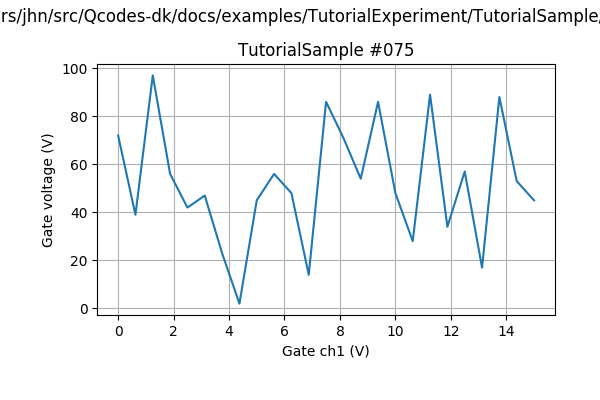

(<qcodes.plots.pyqtgraph.QtPlot at 0x10bb844a8>, DataSet:
    location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/075'
    <Type>   | <array_id>  | <array.name> | <array.shape>
    Setpoint | dac_ch1_set | ch1          | (25,)
    Measured | dmm_voltage | voltage      | (25,))

In [7]:
# For instance, sweep a dac voltage and record with the dmm

do1d(dac.ch1, 0, 15, 25, 0.1, dmm.voltage)
# Call signature: do1d(thing_to_sweep,
#                      sweep_start,
#                      sweep_stop,
#                      number_of_sweep_points,
#                      delay_per_point,
#                      thing_to_measure)

In [8]:
# If you can't be bothered to look at the plot (if, for instance, you are running many do1ds),
# the live plotting can be disabled
do1d(dac.ch1, 0, 15, 25, 0.1, dmm.voltage, do_plots=False)

Started at 2017-10-17 11:30:53
DataSet:
   location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/076'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | dac_ch1_set | ch1          | (25,)
   Measured | dmm_voltage | voltage      | (25,)
Finished at 2017-10-17 11:30:55


(None, DataSet:
    location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/076'
    <Type>   | <array_id>  | <array.name> | <array.shape>
    Setpoint | dac_ch1_set | ch1          | (25,)
    Measured | dmm_voltage | voltage      | (25,))

<IPython.core.display.Javascript object>


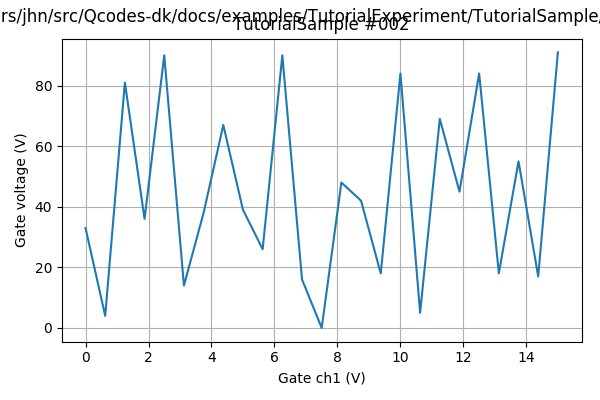

(DataSet:
    location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/002'
    <Type>   | <array_id>  | <array.name> | <array.shape>
    Measured | dmm_voltage | voltage      | (25,)
    Setpoint | dac_ch1_set | ch1          | (25,),
 [<qcodes.plots.qcmatplotlib.MatPlot at 0x115b93fd0>])

In [9]:
# The data may be brought up easily by referecing the unique ID number
show_num(2)

#### Products of `do1d`

The `do1d` function creates a DataSet. 
The representation of the dataset shows what arrays it contains and where it is saved.   
The dataset initially starts out empty (filled with NAN's) and gets filled while the `do1d` is being executed. 

Once the measurement is done, take a look at the file in finder/explorer (the dataset.location should give you the relative path). 
Note also the snapshot that captures the settings of all instruments at the start of the Loop. 
This metadata is also accessible from the dataset and captures a snapshot of each instrument listed in the station. 

In [10]:
dac.snapshot()

{'__class__': 'qcodes.tests.instrument_mocks.DummyInstrument',
 'functions': {},
 'name': 'dac',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'dac_IDN',
   'instrument': 'qcodes.tests.instrument_mocks.DummyInstrument',
   'instrument_name': 'dac',
   'inter_delay': 0,
   'label': 'IDN',
   'name': 'IDN',
   'post_delay': 0,
   'raw_value': {'firmware': None,
    'model': 'dac',
    'serial': None,
    'vendor': None},
   'ts': '2017-10-17 11:28:45',
   'unit': '',
   'vals': '<Anything>',
   'value': {'firmware': None,
    'model': 'dac',
    'serial': None,
    'vendor': None}},
  'ch1': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'dac_ch1',
   'instrument': 'qcodes.tests.instrument_mocks.DummyInstrument',
   'instrument_name': 'dac',
   'inter_delay': 0,
   'label': 'Gate ch1',
   'name': 'ch1',
   'post_delay': 0,
   'raw_value': 15.0,
   'ts': '2017-10-17 11:30:55',
   'unit': 'V',
   'vals': '<Numbers -800

There is also a more human-readable version of the essential information.

In [11]:
dac.print_readable_snapshot()

dac:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'firmware': None, 'serial': None, 'model':...
ch1             :	15 (V)
ch2             :	0 (V)
verbose_channel :	5 (V)



### 2D Loop example <a class="anchor" id="do2d"></a>

The `do2d` function works just the way you would expect.

Started at 2017-10-17 11:31:05
DataSet:
   location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/077'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | dac_ch1_set | ch1          | (25,)
   Setpoint | dac_ch2_set | ch2          | (25, 10)
   Measured | dmm_voltage | voltage      | (25, 10)
Finished at 2017-10-17 11:31:09


<IPython.core.display.Javascript object>


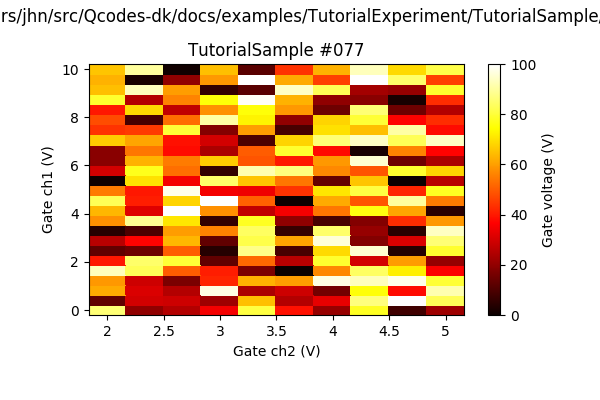

(<qcodes.plots.pyqtgraph.QtPlot at 0x10babb4a8>, DataSet:
    location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/077'
    <Type>   | <array_id>  | <array.name> | <array.shape>
    Setpoint | dac_ch1_set | ch1          | (25,)
    Setpoint | dac_ch2_set | ch2          | (25, 10)
    Measured | dmm_voltage | voltage      | (25, 10))

In [12]:
# Let's ramp those dac voltages!

do2d(dac.ch1, 0, 10, 25, 0.01,  # outer loop
     dac.ch2, 2, 5, 10, 0.01,  # inner loop, i.e. this runs for each point of the outer loop
     dmm.voltage)

The `do2d` function also produces a DataSet, this time noticeably with **two** setpoint arrays.

We can recall an existing plot with show_num. The useQT variable determines if we use pyqtgraph or matplotlib to perform the plot. All other kwargs are forwared to the respective plotting methods. For instance we can change 
the colormap used by matplotlib by passing the cmap variable.

<IPython.core.display.Javascript object>


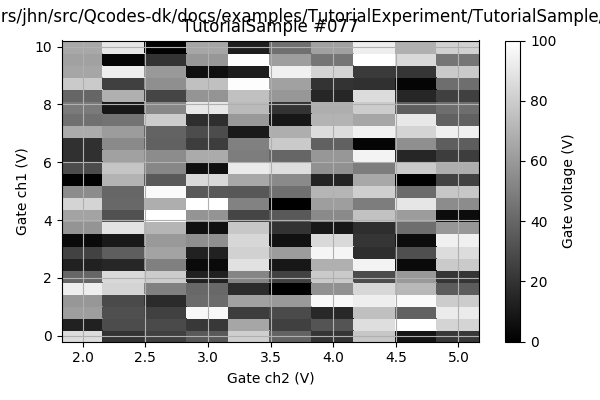

(DataSet:
    location = '/Users/jhn/src/Qcodes-dk/docs/examples/TutorialExperiment/TutorialSample/077'
    <Type>   | <array_id>  | <array.name> | <array.shape>
    Measured | dmm_voltage | voltage      | (25, 10)
    Setpoint | dac_ch1_set | ch1          | (25,)
    Setpoint | dac_ch2_set | ch2          | (25, 10),
 [<qcodes.plots.qcmatplotlib.MatPlot at 0x116b38240>])

In [13]:
show_num(77, useQT=False, cmap='gray')